# Выбор локации для скважины

Фирма «ГлавРосГосНефть» хочет понять, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

Для предсказания построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Задача:** на основании данных о трех локациях для бурения скважин сделать вывод о наиболее выгодном варианте.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler
from scipy import stats as st

In [2]:
df0=pd.read_csv('/datasets/geo_data_0.csv')
df1=pd.read_csv('/datasets/geo_data_1.csv')
df2=pd.read_csv('/datasets/geo_data_2.csv')
all_df=[df0,df1,df2]

In [3]:
print(df0.info(),df1.info(),df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

В данных отсутствуют пропуски, тип данных - числа с плавающей запятой.

In [4]:
print(df0.head(),'\n',df1.head(),'\n',df2.head())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 
       id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305 
       id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


Структура везде одинакова: сначала уникальный id, потом 3 признака и значение product

In [5]:
for i in all_df:
    print(i[i.duplicated('id')==True]['id'].count())

10
4
4


Дубликаты имеются, но их очень мало, меньше 0.1%. На них можно не обращать внимание.

[[<AxesSubplot:title={'center':'f0'}> <AxesSubplot:title={'center':'f1'}>]
 [<AxesSubplot:title={'center':'f2'}>
  <AxesSubplot:title={'center':'product'}>]]
[[<AxesSubplot:title={'center':'f0'}> <AxesSubplot:title={'center':'f1'}>]
 [<AxesSubplot:title={'center':'f2'}>
  <AxesSubplot:title={'center':'product'}>]]
[[<AxesSubplot:title={'center':'f0'}> <AxesSubplot:title={'center':'f1'}>]
 [<AxesSubplot:title={'center':'f2'}>
  <AxesSubplot:title={'center':'product'}>]]


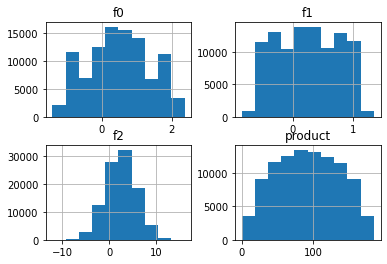

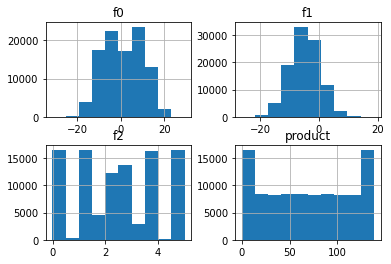

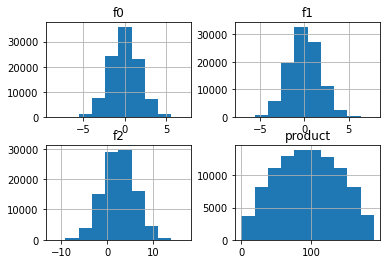

In [6]:
for i in all_df:
    print(i.hist())

In [7]:
for i in all_df:
    print(i.corr())

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


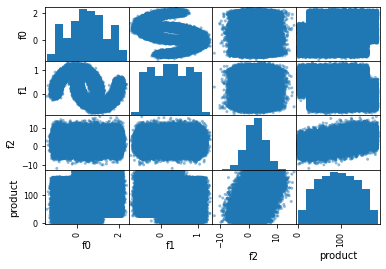

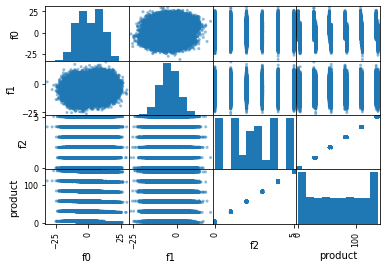

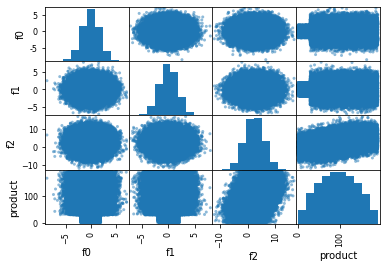

In [8]:
for i in all_df:
    pd.plotting.scatter_matrix(i)

**Вывод**: в третьем датасете данные похожи на распределенные нормально. Кроме того, f2 в 0, f1 в 1 датасетах также похожи на нормальное распределение. Единственная важная корреляция - влияние фактора f2 на product во датасете с индексом 1.

## Обучение и проверка модели

Обучим модель линейной регрессии, при этом заранее стандартизируем данные через StandardScaler. Посчитаем RMSE и средние значения.

In [9]:
reg_num=0
list_res=[0,0,0]
for i in all_df:
    print('-'*15)
    print('info for reg:',reg_num)
    features=i.drop(['id','product'],axis=1)
    target=i['product']

    features_train,features_valid,target_train,target_valid=train_test_split(features,target,test_size=.25,random_state=12345)

    scaler= StandardScaler()
    scaler.fit(features_train)
    features_train=scaler.transform(features_train)
    features_valid=scaler.transform(features_valid)

    
    model=LinearRegression()
    model.fit(features_train,target_train)
    
    prediction=model.predict(features_valid)
    list_res[reg_num]=(pd.Series(prediction),target_valid.reset_index(drop=True))
    print('RMSE:',mean_squared_error(prediction,target_valid)**(0.5),'Mean value:',prediction.mean())
    reg_num+=1

    print('-'*15,'\n')


---------------
info for reg: 0
RMSE: 37.5794217150813 Mean value: 92.59256778438035
--------------- 

---------------
info for reg: 1
RMSE: 0.893099286775617 Mean value: 68.728546895446
--------------- 

---------------
info for reg: 2
RMSE: 40.02970873393434 Mean value: 94.96504596800489
--------------- 



**Вывод**: видим, что 0 и 2 локации частичто похожи друг на друга: у них близкие средние значения, а также корень квадратичной ошибки. На их фоне выделяется первая локация -- там распределение более кучное, но среднее значение ниже, чем у остальных. Возможно, там меньше выбросов

## Подготовка к расчёту прибыли

Сохраним ключевые значения в переменных.

In [10]:
n_pts=500 # кол-во точек
n_best=200 # отборные лучшие точки
budget=1e10 # траты на введение в эксплуатацию
bar_price=450 # $ за баррель
unit_rev=bar_price*1000 # $ за один лот, 1000 баррелей
loss_prob=0.025 # 2.5%


Вычислим, сколько запасов нужно иметь как минимум, чтобы окупить затраты на разработку.

In [11]:
min_prof=budget/unit_rev
print(min_prof)

22222.222222222223


Среди наших отборных 200 скважин среднее значение запасов для прохождения точки безубыточности должно быть следующим:

In [12]:
mean_prof_best=min_prof/n_best
print(mean_prof_best)

111.11111111111111


У нас посчитаны лишь средние по всем точкам на локации, а здесь средние из 200 лучших. Пока мы не можем сравнивать значения, нужно выделить лучшие месторождения.

In [13]:
def profit_pred(prediction,target,n_best=n_best,unit_rev=unit_rev):
    prediction=prediction.sort_values(ascending=False)[:n_best]
    target=target[prediction.index]
    profit=sum(target)*unit_rev
    net_income=profit-budget
    return net_income

## Расчёт прибыли и рисков 

In [14]:
state=RandomState(12345)


Применим бутстреп для 1000 выборов по 500 точек в каждой и выведем требуемую статистическую информацию.

In [15]:
def bootstrap_pred(target,predictions):
    revenues=[]
    for f in range(1000):
        target_sampled=target.sample(n=500,replace=True,random_state=state)
        pred_sampled=predictions[target_sampled.index]
        revenues.append(profit_pred(pred_sampled,target_sampled))
    revenues=pd.Series(revenues)
    return revenues

In [16]:
for i in range(3):
    print('-'*5,'STATISTICS FOR',i,'-'*5)
    rev_final=bootstrap_pred(list_res[i][1],list_res[i][0])
    print('mean value',rev_final.mean())
    print('confidence interval 95%',f'({rev_final.quantile(.025)};{rev_final.quantile(.975)})')
    print(f'risk of losses {st.percentileofscore(rev_final,0):.2}%')    
    print('-'*28,'\n')


----- STATISTICS FOR 0 -----
mean value 600735244.2611659
confidence interval 95% (12948331.135111189;1231163605.7914944)
risk of losses 2.0%
---------------------------- 

----- STATISTICS FOR 1 -----
mean value 663958995.2602141
confidence interval 95% (206476361.25178447;1191197684.7488778)
risk of losses 0.1%
---------------------------- 

----- STATISTICS FOR 2 -----
mean value 597381047.9005234
confidence interval 95% (1734929.5311778623;1246217960.165243)
risk of losses 2.5%
---------------------------- 



Итак, видим, что в регионе с индексом 1 **наибольшая** *средняя прибыль, **минимальный** риск убытков, наиболее **высокая** нижняя граница дов.интервала 95%*. Значит, локация **рекомендована** к разработкею

**ВЫВОД**: на основании данных о трех локациях с различными параметрами с помощью модели линейной регрессии был сделан вывод о наиболее оптимальном (выгодном) расположении буровых установок. Регион с индексом 1 был выбран из-за малой вероятности убытков и большой средней прибыли. 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован